,Time (s),Extensometer (mm),Load (kN),Engineering strain (abs.),Engineering stress (MPa)
0,0.0000,0.000000e+00,0.077946,0.000000e+00,3.300131
1,0.0200,-2.436086e-07,0.077900,-1.624057e-08,3.298197
2,0.0400,-7.425022e-07,0.077961,-4.950015e-08,3.300783
3,0.0600,-9.848433e-07,0.077953,-6.565622e-08,3.300434
4,0.0800,-1.015682e-06,0.077962,-6.771213e-08,3.300809
...,...,...,...,...,...
17596,351.9200,5.974273e+00,8.514951,3.982849e-01,360.512765
17597,351.9400,5.976968e+00,7.107629,3.984645e-01,300.928447
17598,351.9600,5.979644e+00,5.292964,3.986429e-01,224.097718
17599,351.9800,5.982319e+00,3.493323,3.988213e-01,147.903086


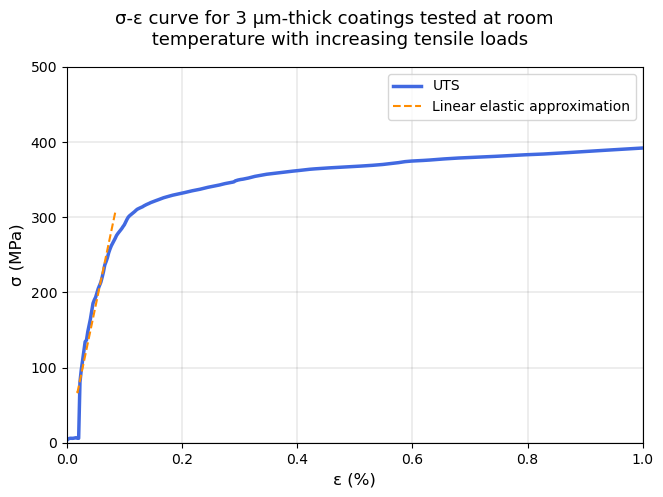

,Load (kN),R² value,Linear regression reliability,Approximate incremental modulus (GPa)
0,UTS,0.959396,VERY GOOD,365


In [13]:
#---------------------------------------------|| PHYTON CLASSES AND LIBRARIES ||---------------------------------------------#

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorama, statistics
from scipy.interpolate import griddata
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from colorama import Fore, Style, Back
from statistics import mean 
from scipy import stats

#-------------------------------------------------|| DECLARED FUNCTIONS ||--------------------------------------------------#


def engineering_stress(load):
    A0 = 23.619  
    return load*1000/A0

def engineering_strain(extension): 
    L0 = 15 
    return extension/L0

def median_value(array):
    sum_val = 0
    for i in range (0, array.shape[0]):
        sum_val += array[i]
    return sum_val/array.shape[0]  

def r2regression(valori_reali, valori_attesi):
    RSS = float(0)
    TSS = float(0)
    media = median_value(valori_reali) 
    for i in range (0, valori_reali.shape[0]):
        RSS += (valori_reali[i] - valori_attesi[i])**2
        TSS += (valori_reali[i] - media)**2
    return round(float(1-RSS/TSS), 4)

def regression_reliability(r2):
    if(r2>=0.95):
        return 'VERY GOOD'
    elif(r2<0.95 and r2>=0.90):
        return 'ADMISSIBLE'
    else:
        return 'NOT GOOD'

#-------------------------------------------------|| EXCEL FILES IMPORT ||--------------------------------------------------#

'''
The Pandas software library is employed to import all excel data and create the corresponding Dictionary (hereby called 'data').
Thus, a DataFrame is generated for each excel sheet loaded before. Each column is renamed for the sake of comprensibility; the 
engineering strain and stress are computed according to the functions defined in the "declared functions" section of the script.
'''

# create the general dictionary
data = pd.read_excel(r'C:\Users\Federico\Desktop\PhD\EXAMS\PHYTON DRIVING LICENSE\PROJECT_EXAM\RTdegC(3,0).xlsx', sheet_name=[0], usecols=[8, 9, 10, 11], header = 1)

# create the 1st DataFrame from the general dictionary
df = pd.DataFrame.from_dict(data[0], orient='columns')
df = df.rename(columns={'time[s].1':'Time (s)', 'crosshead[mm].1':'Crosshead (mm)', 'extensometer[mm].1':'Extensometer (mm)','force[kN].1':'Load (kN)'})
df['Engineering strain (abs.)'] =  engineering_strain( df['Extensometer (mm)'] )
df['Engineering stress (MPa)'] =  engineering_stress( df['Load (kN)'] )
del df['Crosshead (mm)']
display(df)

#-----------------------------------------------|| LINEAR INTERPOLATION ||------------------------------------------------#

# interpolate the 1st set of data
X = df['Engineering strain (abs.)']
Y = df['Engineering stress (MPa)']
interpolation_function = interp1d(X, Y, kind = 'linear')
interpolation_points = np.linspace(0, df.iloc[-1]['Engineering strain (abs.)'], Y.shape[0])
interpolated_value = interpolation_function(interpolation_points)

#-----------------------------------------------|| LINEAR REGRESSION ||------------------------------------------------#

# 1st linear regression
X1 = X[6500:7400].values.reshape(-1,1)
Y1 = Y[6500:7400].values.reshape(-1,1)
regressor = LinearRegression(fit_intercept = False).fit(X1, Y1)
# print(regressor.intercept_) --> to verify that the straight line effectively passes through the origin  
y_estimated = regressor.predict(X1)
incremental_modulus = int(regressor.coef_/1000)

#-----------------------------------------------|| PLOTS AND GRAPHICS ||------------------------------------------------#

''' 
STRESS VS. STRAIN CURVE
The interpolation points, spanning all the engineering strain values, are represented on the x-axis. Notice that each strain 
value is multiplied by 100, to express the percent engineering strain [%]. The interpolated values [MPa] are plotted on the 
y-axis.
'''
plt.plot(interpolation_points*100, interpolated_value, linestyle='solid', linewidth=2.5, color = 'royalblue', label = 'UTS')
''' 
LINEAR REGRESSION
The linear elastic approximation is represented with a dashed line. The x-values are all the percent engineering strains, 
while the y-values are estimated based on the previous linear regression.
'''
plt.plot(X1*100, y_estimated, linestyle='dashed', linewidth=1.5, color = 'darkorange', label = 'Linear elastic approximation')

''' 
GRAPHICS 
'''
# title of the image
plt.suptitle('\u03C3-\u03B5 curve for 3 \u03BCm-thick coatings tested at room \n temperature with increasing tensile loads', horizontalalignment='center', verticalalignment='top', fontsize = 13)

# general layout amelioration
plt.tight_layout(pad=1)

# axis and grid
plt.xlabel('\u03B5 (%)', fontsize = 12) 
plt.ylabel('\u03C3 (MPa)', fontsize = 12)
plt.grid(color='k', linewidth=0.1)
plt.xlim(0,1)
plt.ylim(0,500)

# legend
plt.legend()

# visualization of all diagrams
plt.show()

''' 
NUMERICAL RESULTS
A new DataFrame containing the numerical results is created.
'''
# generation of 4 different lists of results
pulling_force = ['UTS']
r2_results = [r2_score(Y1, y_estimated)]
r2_reliability = [regression_reliability(r2_score(Y1, y_estimated))]
incremental_moduli = [incremental_modulus]

# creation of the corresponding DataFrame (N.B: each list is added to the DataFrame by way of the "zip" function)
df_results = pd.DataFrame(list(zip(pulling_force, r2_results, r2_reliability, incremental_moduli)), columns =['Load (kN)', 'R\u00b2 value', 'Linear regression reliability', 'Approximate incremental modulus (GPa)'])

# visualization of the final results
display(df_results.style.set_properties(**{'text-align': 'center'}))
